In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMCoarseDataset, display_data_loader_batch

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 80
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

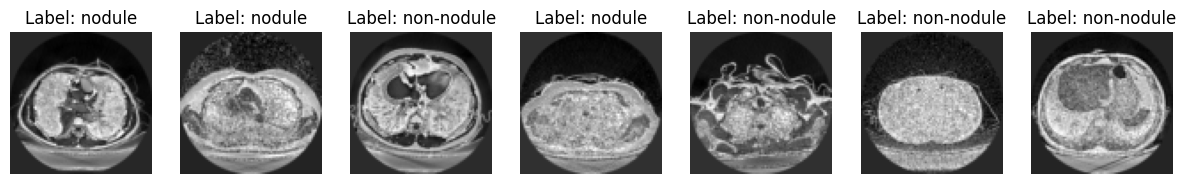

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
    transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                    scale=(0.8, 1.2),  # Scale for zoom in/out
                    ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
    transform
])

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], transform=transform)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

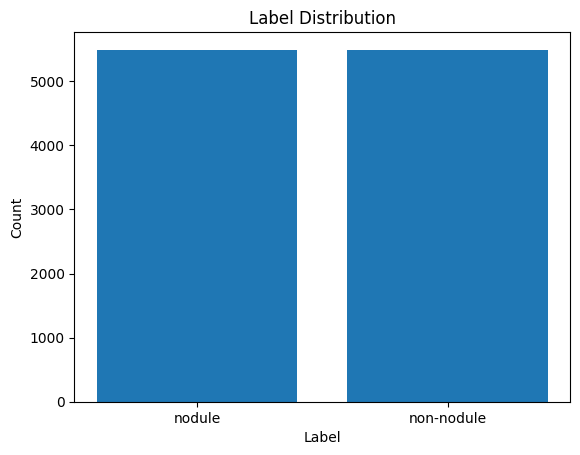

In [4]:
dataset.display_label_distribution()

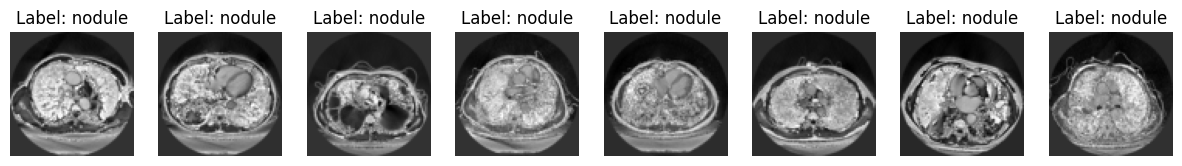

In [5]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

In [6]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
  )
)


In [7]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [8]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 7.07399416
Epoch: 1 	Training Loss: 3.50844288
Epoch: 1 	Training Loss: 3.36475611
Epoch: 1 	Training Loss: 3.33182120
Epoch: 1 	Training Loss: 3.24946928
Epoch: 1 	Training Loss: 2.99854422
Epoch: 1 	Training Loss: 2.90935445
Epoch: 1 	Training Loss: 2.74949336
Epoch: 1 	Training Loss: 2.56369400
Epoch: 1 	Training Loss: 2.48565674
Epoch: 1 	Training Loss: 2.27083540
Epoch: 1 	Training Loss: 2.07911253
Epoch: 1 	Training Loss: 2.02579117
Epoch: 1 	Training Loss: 1.78219521
Epoch: 1 	Training Loss: 1.84420991
Epoch: 1 	Training Loss: 1.70700598
Epoch: 1 	Training Loss: 1.72477150
Epoch: 1 	Training Loss: 1.67669880
Epoch: 1 	Training Loss: 1.64195156
Epoch: 1 	Training Loss: 1.57072580
Epoch: 1 	Training Loss: 1.60340786
Epoch: 1 	Training Loss: 1.61690235
Epoch: 1 	Training Loss: 1.53390193
Epoch: 1 	Training Loss: 1.51538062
Epoch: 1 	Training Loss: 1.49519873
Epoch: 1 	Training Loss: 1.54384780
Epoch: 1 	Training Loss: 1.44505024
Epoch: 1 	Training Loss: 1.5

Test Loss: 1.02680782

Test Accuracy of     0: 94.58% (1064/1125)
Test Accuracy of     1: 82.39% (884/1073)

Test Accuracy (Overall): 88.63% (1948/2198)


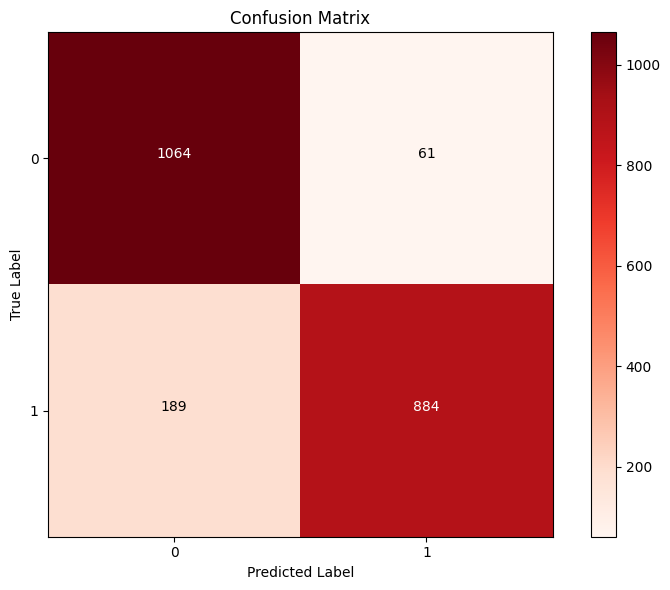

In [12]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

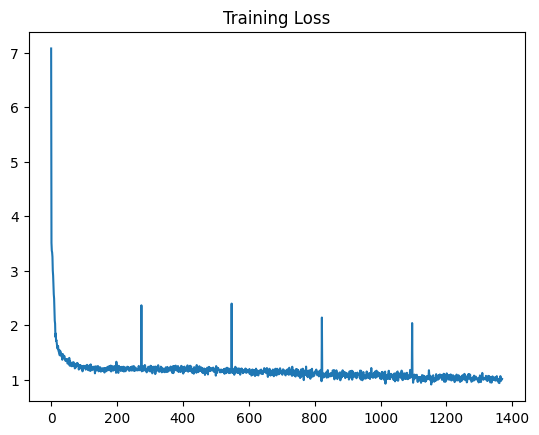

In [10]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

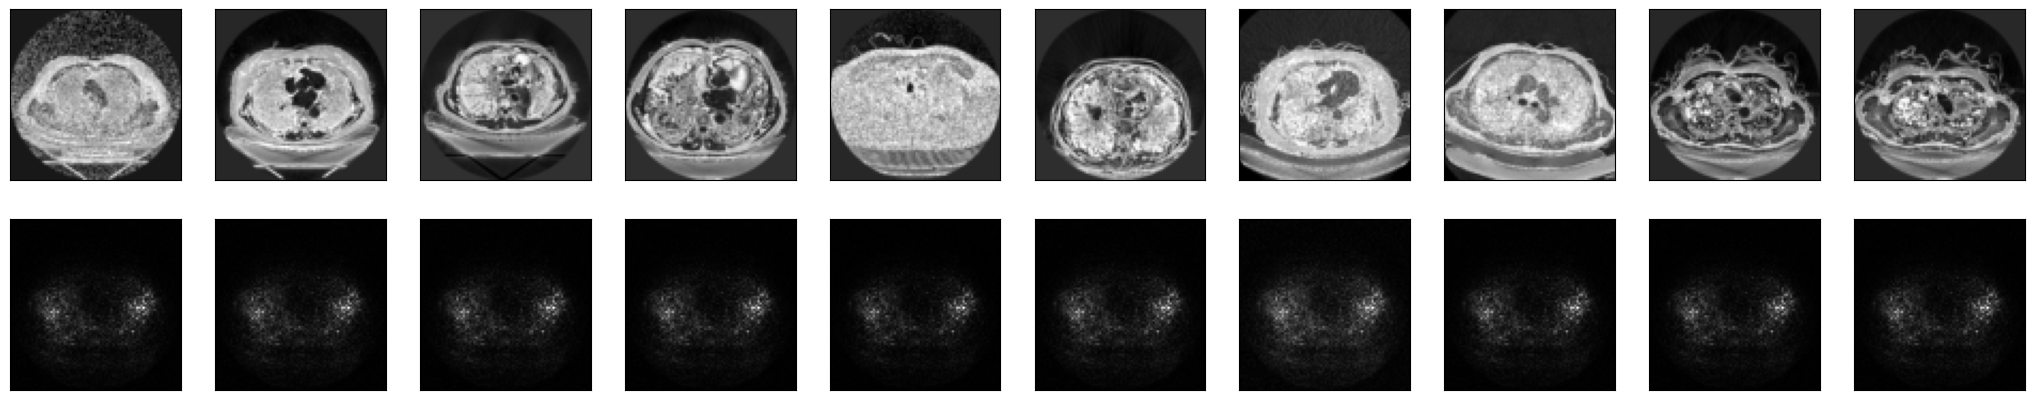

In [11]:
display_images(images, reconstructions)